In [1]:
import numpy as np
import scipy as sc
import scipy.interpolate as sc_int
from matplotlib import pyplot as plt
import geometry
import mdp
%matplotlib inline

def label_graph (xl, yl, title, leg = True):
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    if leg: plt.legend()

In [2]:
# room size:
rs_r = np.array([10,5])
rs_q = np.array([5,5])

#determines next step given a location    
def get_next_step (drn, pos, rot_var, speed_mean, speed_var):
    next_rad=-1
    while next_rad <= 0:
        next_rad = np.random.randn(1)*speed_var**0.5+speed_mean
    new_drn = (np.random.randn(1)*rot_var**0.5 + drn)%(2*np.pi)
    new_pos = np.zeros(2)
    new_pos[0] = pos[0] + np.sin(new_drn)*next_rad
    new_pos[1] = pos[1] + np.cos(new_drn)*next_rad
    return new_pos, new_drn


# generates a random flight     
def random_flight (rot_var, speed_mean, speed_var, rs, steps = 100, init_pos = -np.random.rand(2), acc = 0.01):
    '''
    uses:
    '''
    if np.sum(init_pos)<0: init_pos = -init_pos*rs
    drn = np.random.rand()*2*np.pi
    positions = np.zeros((steps+1,2))
    positions[0,:] = init_pos
    directions = np.zeros(steps+1)
    directions[0] = drn
    for i in range(steps):
        new_pos, new_drn = get_next_step (drn,positions[i,:],rot_var,speed_mean, speed_var)
        while outside(new_pos, rs):
            new_pos, new_drn = get_next_step (drn,positions[i,:],rot_var,speed_mean, speed_var)
        positions[i+1, :] = new_pos
        drn = new_drn
        directions[i+1] = drn
    return positions, directions
 
#returns if a point lies outside the area
def outside(pos, rs):
    if any (pos<0) or any (pos>rs):
        return True
    else: return False

#gives back the sensory input for one certain position and head direction of the bat
def sens_in_cur (pos, sens_drn, rs):
    res = np.zeros(len(sens_drn))
    for i in range(len(sens_drn)):
        sin_s = np.sin(sens_drn[i])
        cos_s = np.cos(sens_drn[i])
        x_dis = rs[1]*10 #just some aribitrary large values
        y_dis = rs[0]*10  
        #x direction (as the bat is facing 'up' the directions are rotated)
        if np.isclose(sin_s, 0.): #then the y direction is closer anyways
            pass
        elif sin_s>0:
            x_dis = (rs[0]-pos[0])/sin_s
        else:
            x_dis = (0.-pos[0]/sin_s)         
        #y direction
        if np.isclose(cos_s, 0.):
            pass
        elif cos_s >0:
            y_dis = (rs[1]-  pos[1])/cos_s
        else:
            y_dis = (0.-pos[1]/cos_s)       
        res[i] = min([x_dis, y_dis])
    return res      
    
#plot the flight
def plot_flight_raw (pos, rs):
    plt.plot(pos[:,0], pos[:,1])
    plt.plot(pos[0,0],pos[0,1], 'go')
    plt.plot(pos[-1,0], pos[-1,1], 'ro')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, rs[0])
    plt.ylim(0, rs[1])

#given the flight parameters, this routine returns the input of the sensors    
def get_sensory_input(pos, drns, sens_drns, rs, absolute_dir = True):
    res = np.zeros((len(drns),len(sens_drns)))
    for i in range(len(drns)):
        if not absolute_dir:
            cur_dir = drns[i]+sens_drns
        else:
            cur_dir = sens_drns
        res[i] = sens_in_cur(pos[i], cur_dir, rs)
    return res


    

    
#those  methods were supposed to check if all places in the cell have been covered more or less equally,
#however I did not manage to make them run and I actually don't think we really need them 
def check_coverage(pos, rs, acc = 0.2):
    meshx, meshy = np.meshgrid(np.arange(0, rs[0]+acc, acc), np.arange(0, rs[1]+acc, acc))
    res = np.zeros((meshx.shape[0]-1, meshy.shape[1]-1))
    for i in range(meshx.shape[0]-1):
        for j in range(meshy.shape[1]-1):
            #handmade 2D histogram function
            res[meshx.shape[0]-2-i,meshx.shape[1]-2-j] = np.sum(np.logical_and(np.logical_and(pos[:,0]>meshx[i,j], pos[:,0]<=meshx[i+1,j+1], pos[:,1]>meshy[i,j]), pos[:,1]<=meshy[i+1,j+1]))            
    plt.pcolor(res)
    plt.colorbar()
    
def check_coverage2(pos, rs, acc):
    plt.figure()
    h = int(rs[0]/acc)
    w = int(rs[1]/acc)
    res = np.zeros((h,w))
    pos[:,0] = pos[:,0]/rs[0]*h
    pos[:,1] = pos[:,1]/rs[1]*w
    for i in range(h):
        subp = pos[np.where(np.logical_and(pos[:,0]>i, pos[:,0]<= i+1))]
        for j in range(w):
            ps = subp[np.where(np.logical_and(subp[:,1]>j, subp[:,1]<= j+1))]
            res[i,j] = len(ps)
    plt.pcolor(res)
    plt.colorbar()
        
        
        

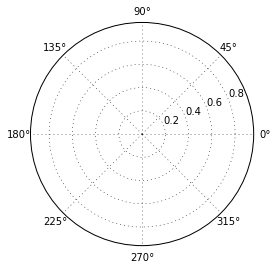

In [3]:
#?plt.polar
test_dir = np.arange(0, 2*np.pi, 180)
plt.polar(test_dir, 0.9*np.ones(len(test_dir)), 'r')

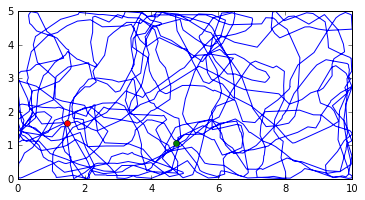

In [4]:
#number 1

pos, drns = random_flight (0.4, 0.2, 0.1,rs_r, 1000)
#check_coverage2(pos, rs_r, 0.5)
plt.figure()
plot_flight_raw(pos, rs_r)

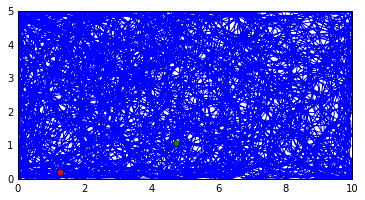

In [5]:
#1.2
pos, drns = random_flight (0.4, 0.2, 0.1, rs_r, 10000)
plt.figure()
plot_flight_raw(pos, rs_r)
res = get_sensory_input(pos, drns, [0., 0.5*np.pi], rs_r,True)
#check_coverage2(pos, rs_r, 0.5)
#plt.figure()
#plt.plot(res)


**1.3** 
As the sensors have a fixed direction wrt the room, t

In [6]:
#1.3

#set up and train the sfa
def train_sfa (dat, p_exp, o_dim, sv = False, red = False):
    flow = (mdp.nodes.PolynomialExpansionNode(p_exp)+
        mdp.nodes.WhiteningNode(svd = sv, reduce = red) +
        mdp.nodes.SFANode(output_dim=o_dim))
    flow.train(dat)
    return flow

#take the trained SFA object and apply it on a meshgrid. Plot results
def vis_components (trained_sfa, sens_dir, n , rs, acc = 0.2, plot = True, new_fig = True):
    #set up meshgrid
    meshx, meshy = np.meshgrid(np.arange(0, rs[0], acc), np.arange(0, rs[1], acc))
    mesh = np.vstack((meshx.flatten(), meshy.flatten())).T
    res = np.zeros((len(mesh), len(sens_dir)))
    #get the sensory input for all sensors at all meshgrid points
    for i in range(len(mesh)):
        res[i,:] = sens_in_cur(mesh[i,:], sens_dir, rs)
    #feed into trained sfa
    out = trained_sfa(res)
    if plot:
        #if you set n too high, this will no longer give you an error (so if you dont know how many components you have, just make n a large number)
        if n>len(out[0,:]): 
            n = len(out[0,:])
            print('n is set too high, all components (' + str(n) + ') will be plotted')
        if new_fig:
            #pretty complicated, it just turned out that squares and rectangles are better shown differently
            if rs[1] == rs[0]: plt.figure(figsize = (6, 3.5*np.ceil(n/2)))
            else: plt.figure(figsize = (6, n*rs[1]/rs[0]*6))
        for i in range(n):
            #again square vs rectangle complications
            if rs[1] == rs[0]: plt.subplot(int(np.ceil(n/2)),2,i+1)
            else: plt.subplot(n,1,i+1)
            plt.pcolor(out[:,i].reshape(meshx.shape))
            plt.gca().set_aspect('equal', adjustable='box')
    return out        

#plots the directions of the sensors
def vis_sens_dir (s_dir):
    plt.figure()
    for i in range(len(s_dir)):
        plt.plot([0,np.sin(s_dir[i])], [0, np.cos(s_dir[i])], label = str(i))
    plt.legend()
    plt.title('directions of the components')
    plt.axis('equal')
    plt.ylim(-1.2, 1.2)
    

        


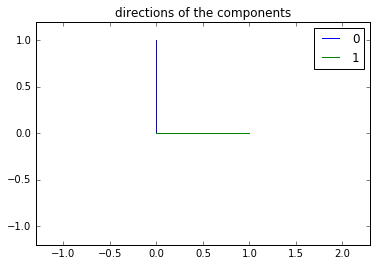

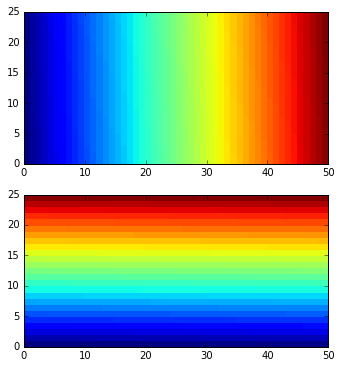

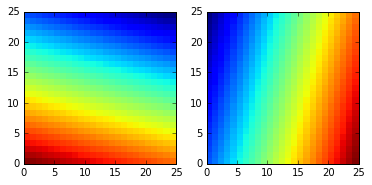

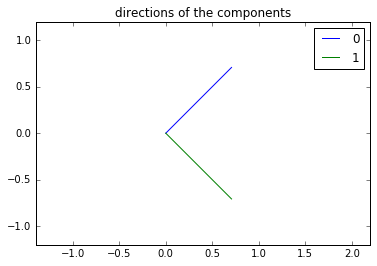

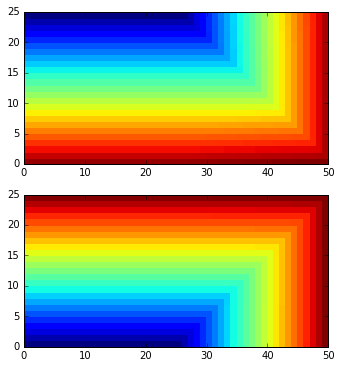

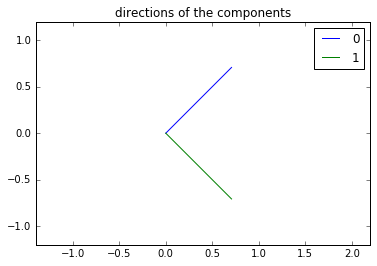

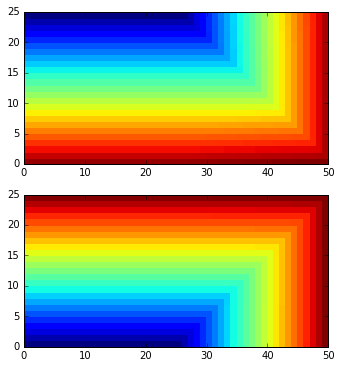

In [7]:
#for a rectangular box
pos, drns = random_flight (0.4, 0.2, 0.1, rs_r, 5000)
s_dir = [0., 0.5*np.pi]
res = get_sensory_input(pos, drns, s_dir, rs_r, True)
rect_sfa = train_sfa(res,1, 2)
vis_sens_dir(s_dir)
vis_components(rect_sfa, s_dir, 2, rs_r)
#vis_head_dir(rect_sfa, s_dir, rs_r, 1)

#for the quadratic box
pos_q, drns_q = random_flight (0.4, 0.2, 0.1, rs_q,5000)
res_q = get_sensory_input(pos_q, drns_q, [0., 0.5*np.pi],rs_q, True)
quad_sfa = train_sfa(res_q, 1, 2)
vis_components(quad_sfa, s_dir, 2, rs_q)  



#for another rectangular box, but with sensors that are not parallel to the wall
s_dir2 = [0.25*np.pi, 0.75*np.pi]
res2 = get_sensory_input(pos, drns, s_dir2, rs_r, True)
rect_sfa2 = train_sfa(res2, 1, 2)
vis_sens_dir(s_dir2)
aux = vis_components(rect_sfa, s_dir2, 2, rs_r)
#use some whitening
s_dir2 = [0.25*np.pi, 0.75*np.pi]
res2 = get_sensory_input(pos, drns, s_dir2, rs_r, True)
rect_sfa2 = train_sfa(res2, 1, 2, True) 
vis_sens_dir(s_dir2)
aux = vis_components(rect_sfa, s_dir2, 2, rs_r)



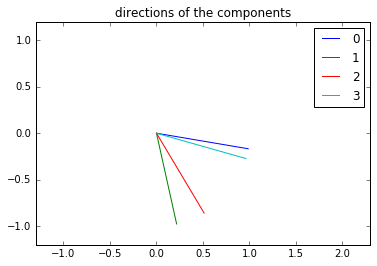

In [8]:
#1.4
#four components
rs_m = np.array([8,4])
pos, drns = random_flight (0.4, 0.2, 0.1, rs_m, 5000)
s_dir4 = np.random.rand(4)*np.pi #only allow half of the radius so that they are more correlated
res4 = get_sensory_input(pos, drns, s_dir4,rs_m, True)
vis_sens_dir(s_dir4)

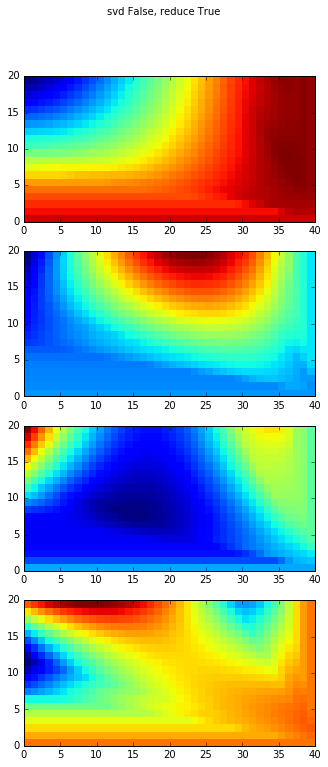

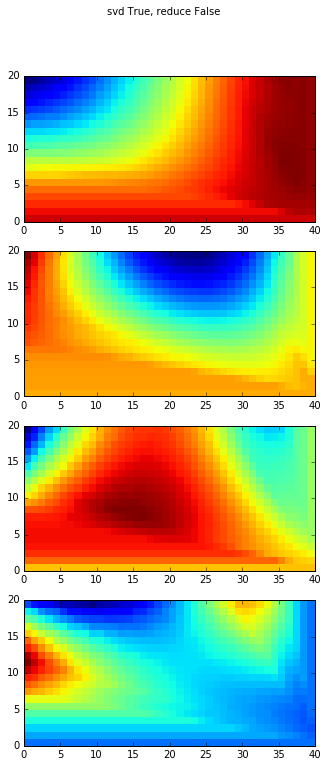

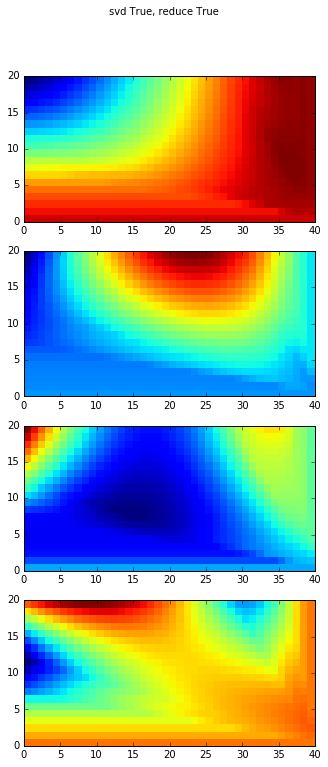

In [9]:
#comparing different whitening techniques    
sfa4_2 = train_sfa(res4, 3, 4, False, True)
out_red = vis_components(sfa4_2,s_dir4, 4, rs_m)
plt.suptitle('svd False, reduce True')

sfa4_3 = train_sfa(res4, 3, 4, True, False)
out_svd = vis_components(sfa4_3,s_dir4, 4, rs_m)
plt.suptitle('svd True, reduce False')

sfa4_4 = train_sfa(res4, 3, 4, True, True)
out_both = vis_components(sfa4_4,s_dir4, 4, rs_m)
plt.suptitle('svd True, reduce True')

-0.0813354584339
0.0559099987086


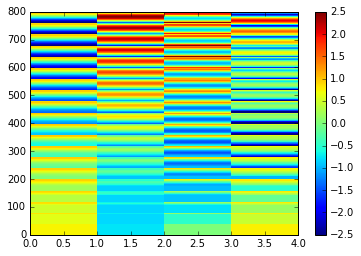

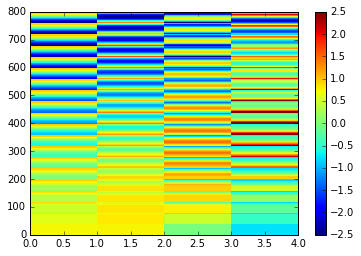

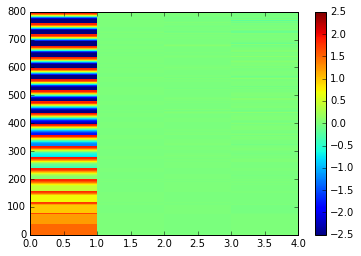

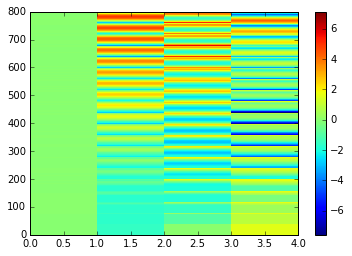

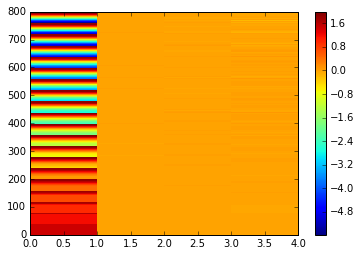

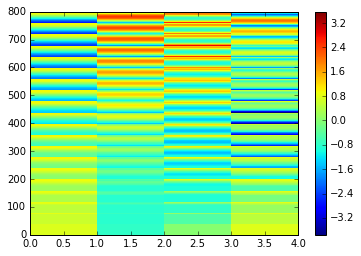

In [10]:
#the following figures are an attempt to see how the svd and reduce 
#method differ and not directly relevant for any question

plt.pcolor(out_red, vmin = -2.5, vmax = 2.5)
plt.colorbar()
plt.figure()
plt.pcolor(out_svd, vmin = -2.5, vmax = 2.5)
plt.colorbar()
print (np.mean(out_red))
print (np.mean(out_svd))
plt.figure()
plt.pcolor(out_red+out_svd, vmin = -2.5, vmax = 2.5)
plt.colorbar()

plt.figure()
plt.pcolor(out_both-out_svd)
plt.colorbar()

plt.figure()
plt.pcolor(out_red+out_svd)
plt.colorbar()

plt.figure()
plt.pcolor(out_both)
plt.colorbar()
#as we can see, for the components, the values of out_svd =~ -out_red
#if both are used, then for some components it is the one way, for others the other. 
#Why??


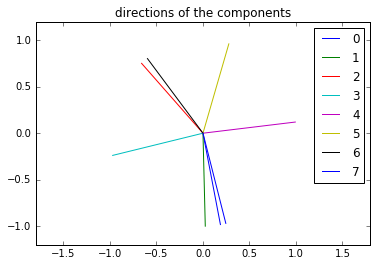

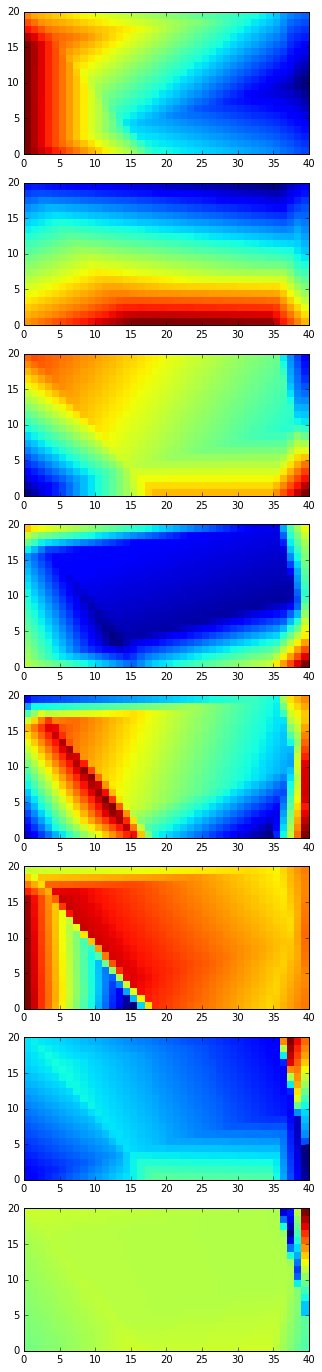

In [11]:
#eight components
s_dir8 = np.random.rand(8)*2*np.pi
vis_sens_dir(s_dir8)
res8 = get_sensory_input(pos, drns, s_dir8,rs_m, True)
sfa8 = train_sfa(res8, 1, 8, True, False)
aux = vis_components(sfa8,s_dir8, 8, rs_m)

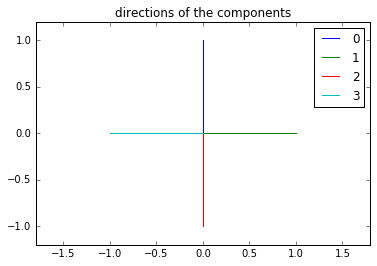

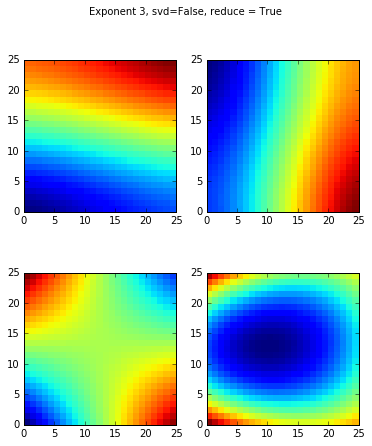

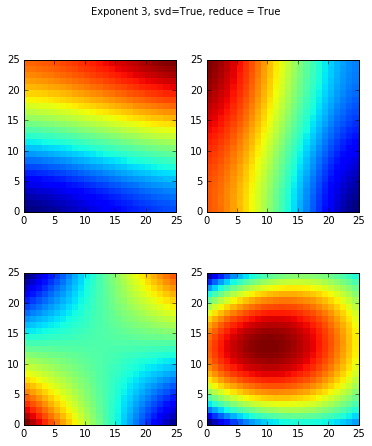

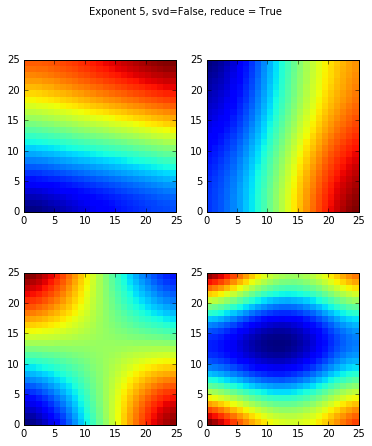

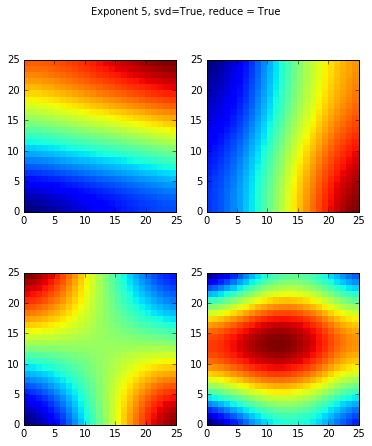

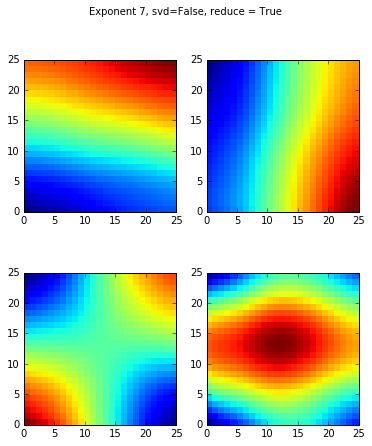

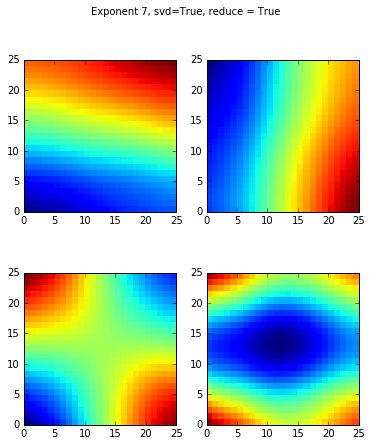

In [12]:
#1.5 Varying the orders of the exponential expansions in different geometries
rs_l = [8,2]

#s_dir = [0., 0.5*np.pi]
n_sens = 4
#s_dir = np.random.rand(n_sens)*2*np.pi 
s_dir = [0, 0.5*np.pi, np.pi, 1.5*np.pi]
vis_sens_dir(s_dir)
pos_q, drns_q = random_flight (0.4, 0.2, 0.1, rs_q,5000)
res_q = get_sensory_input(pos_q, drns_q, s_dir,rs_q, True)

for e in [3,5,7]:
    sfa_q = train_sfa(res_q, e, n_sens, False, True)
    aux = vis_components(sfa_q, s_dir, n_sens, rs_q) 
    plt.suptitle('Exponent ' + str(e)+ ', svd=False, reduce = True')
    sfa_q = train_sfa(res_q, e, n_sens, True, True)
    aux = vis_components(sfa_q, s_dir, n_sens, rs_q)
    plt.suptitle('Exponent ' + str(e)+ ', svd=True, reduce = True')

#sfa_q5 = train_sfa(res_q, 5, n_sens, False, True)
#aux = vis_components(sfa_q5, s_dir, n_sens, rs_q)

#sfa_q7 = train_sfa(res_q, 7, n_sens, False, True)
#aux = vis_components(sfa_q7, s_dir, n_sens, rs_q) 



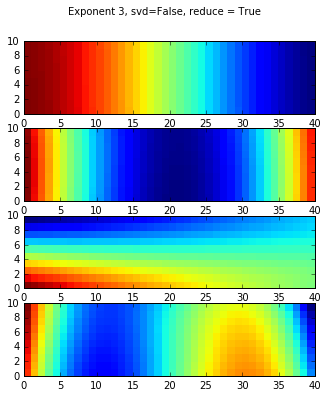

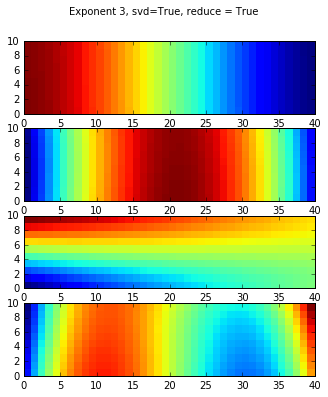

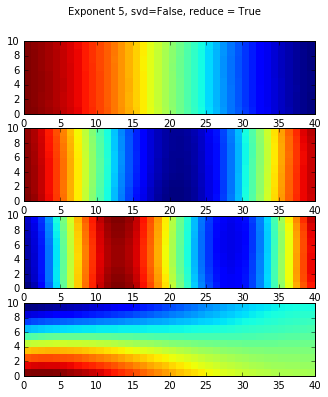

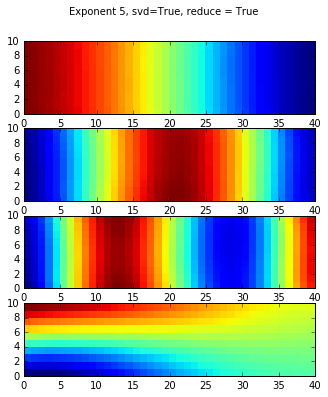

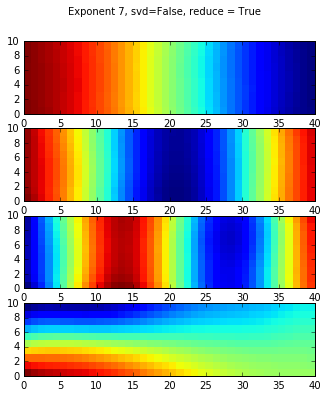

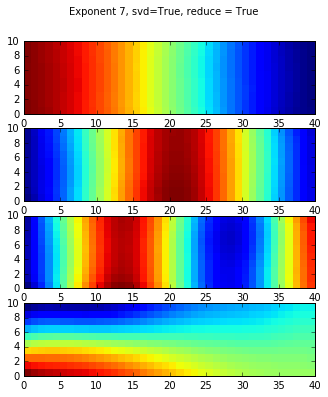

In [13]:
#now the same for the rectangular environment
pos_l, drns_l = random_flight (0.4, 0.2, 0.1, rs_l, 5000)
res_l = get_sensory_input(pos_l, drns_l, s_dir,rs_l, True)

for e in [3,5,7]:
    sfa_l = train_sfa(res_l, e, n_sens, False, True)
    aux = vis_components(sfa_l, s_dir, n_sens, rs_l) 
    plt.suptitle('Exponent ' + str(e)+ ', svd=False, reduce = True')
    sfa_l = train_sfa(res_l, e, n_sens, True, True)
    aux = vis_components(sfa_l, s_dir, n_sens, rs_l)
    plt.suptitle('Exponent ' + str(e)+ ', svd=True, reduce = True')


**1.7** The patterns for the independent components look like the firing patterns of grid/place cells! o.o

n is set too high, all components (77) will be plotted


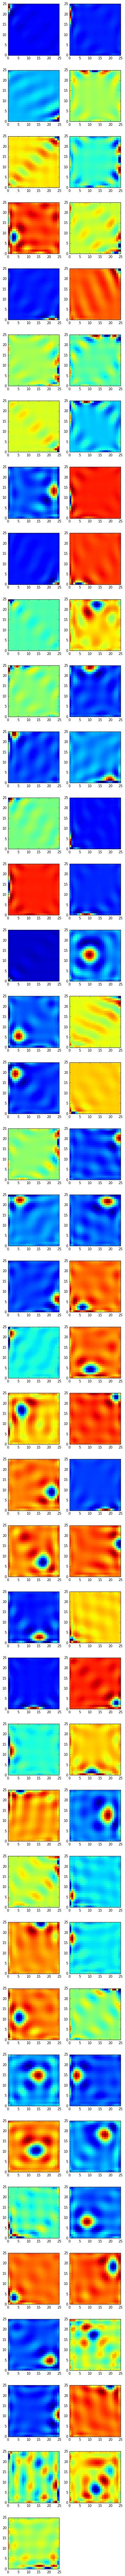

In [14]:
def sfa_ica (dat, p_exp, sv = False, red = False):
    flow = (mdp.nodes.PolynomialExpansionNode(p_exp)+
        mdp.nodes.WhiteningNode(svd = sv, reduce = red) +
        mdp.nodes.SFANode()+
        mdp.nodes.CuBICANode())
    flow.train(dat)
    return flow

si = sfa_ica(res_q, 11, True, True)
aux = vis_components(si, s_dir, 100 , rs_q)


**1.9:** If the sensors are fixed to the head of the bat and turn with it, the bat will still detect the slowest component to be the one crossing a rectangle environment. The second  slowest component can also be the diagonal though. There is even a way to let the bat find the slowest component with only one sensor, namely if one combines that information with the one indicating the direction of the bat's head.

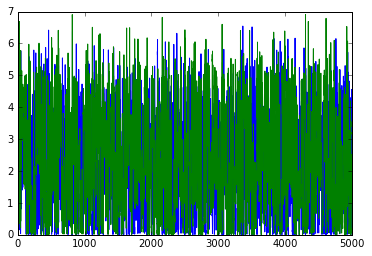

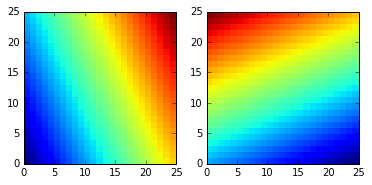

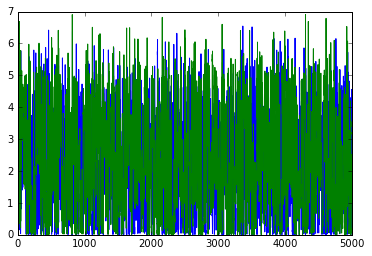

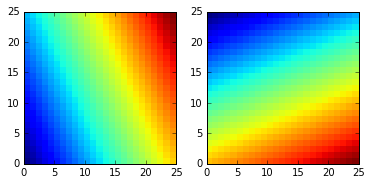

In [15]:
#for when the sensors turn with the head
rs_l = [5,5]
s_dir = [0., 0.5*np.pi] #orientation wrt head
pos_q, drns_q = random_flight (0.4, 0.2, 0.1, rs_l,5000)
res_q = get_sensory_input(pos_q, drns_q, s_dir,rs_l, False)
quad_sfa = train_sfa(res_q, 1, 2)
plt.figure()
plt.plot(res_q)
aux = vis_components(quad_sfa, s_dir, 2, rs_l)
#just some check if whitening has an influence
quad_sfa2 = train_sfa(res_q, 1, 2, True, True)
plt.figure()
plt.plot(res_q)
aux = vis_components(quad_sfa2, s_dir, 2, rs_l)


n is set too high, all components (31) will be plotted


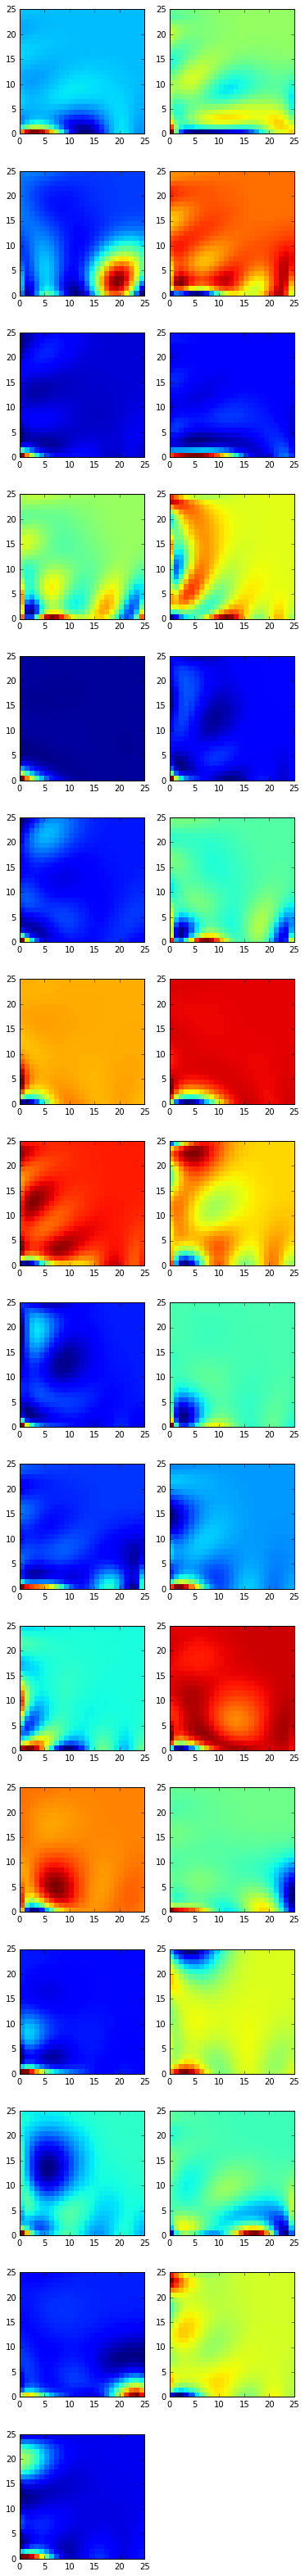

In [16]:
# ica of the above data
indc_sfa = sfa_ica(res_q, 11, True, True)
aux = vis_components(indc_sfa, s_dir, 100, rs_l)

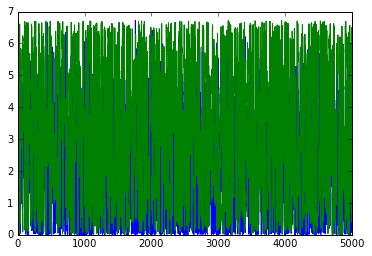

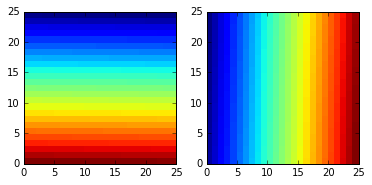

In [17]:
#Only one component!
rs_l = [5,5]
pos_q, drns_q = random_flight (0.4, 0.2, 0.1, rs_l,5000)
res_q = get_sensory_input(pos_q, drns_q, [0.],rs_l, False)
#take the head direction, scale it so it has the same amplitude as
#the sensor input and then feed both informations to the sfa.
d_q2 = np.expand_dims(drns_q/max(drns_q)*max(res_q), 1)
inp = np.hstack((res_q,d_q2))
quad_sfa = train_sfa(inp, 1, 2)
plt.figure()
plt.plot(inp)
aux = vis_components(quad_sfa, s_dir, 2, rs_l)



n is set too high, all components (29) will be plotted


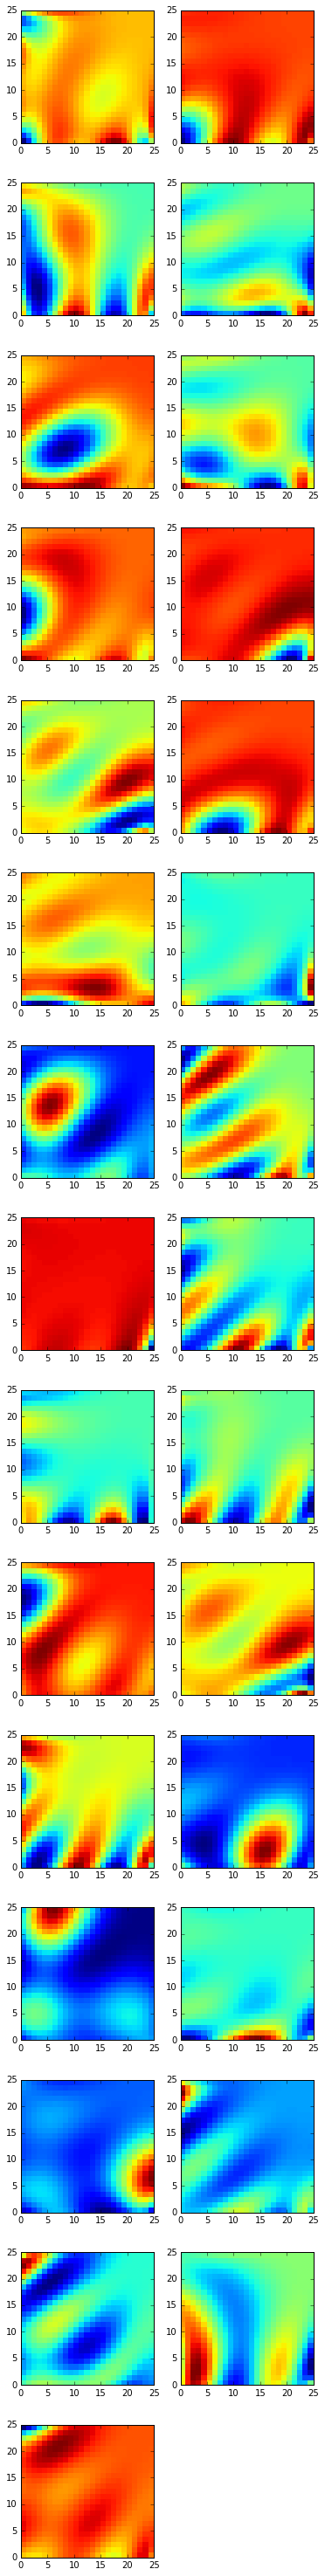

In [18]:
indc_sfa = sfa_ica(inp, 9, True, True)
aux = vis_components(indc_sfa, s_dir, 100, rs_l)
